In data science the challenges we try to address consist on fitting models to data.  The objective is to determine the optimum parameters that can best describe the data.  For example, if we have the following linear model:

<center>$y = \beta_0+\beta_1X_1+\beta_2X_2$</center>

we want to determine the optimum $\beta$'s that best fits the observed values of $y$.

A challenge that we constantly face is that the range of the values of $X_i$ can be different.  For example, $X_1$ and $X_2$ can range from $0-1$ and $0-1e^{20}$, respectively. Therefore, the algorithms that try to extract the $\beta$'s will perform poorly.

In this post we will demonstrate the challenges observed when the ranges of each feature are different, and how to address them by applying a normalization technique. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler

pd.set_option('display.float_format', '{:.2g}'.format)
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

#### Creating the data set

We start by creating three data sets with one feature ($X$) as plotted below. The range of $X$ is $0-1e^{-20}$, $0-1$ and $0-1e^{20}$ for the "Low", "Medium" and "High" datasets, respectively. The $y$-values have the same range across all three data sets.

In [2]:
X_med = np.linspace(0,1,1001)
X_high = 1e20*X_med
X_low = 1e-20*X_med
y_real = np.cos(2/3*2*np.pi*X_med-np.pi/8)
y = y_real + (np.random.randn(len(X_med)))/5 # add some noise

In [3]:
def plot_resuts(sub_plt_num,X,y_real,y,title,y_pred = np.empty(0)):
    plt.subplot(1,3,sub_plt_num)
    plt.plot(X,y_real,color='red',linewidth=3)
    plt.scatter(X,y,s=0.1,color='blue')
    plt.title(title)
    plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    
    # if there is a prediction
    if y_pred.any():
        plt.plot(X,y_pred,'g--',linewidth=3)
        plt.legend(['Ground Truth','Model','Data'])
    else:
        plt.legend(['Ground Truth','Data'])

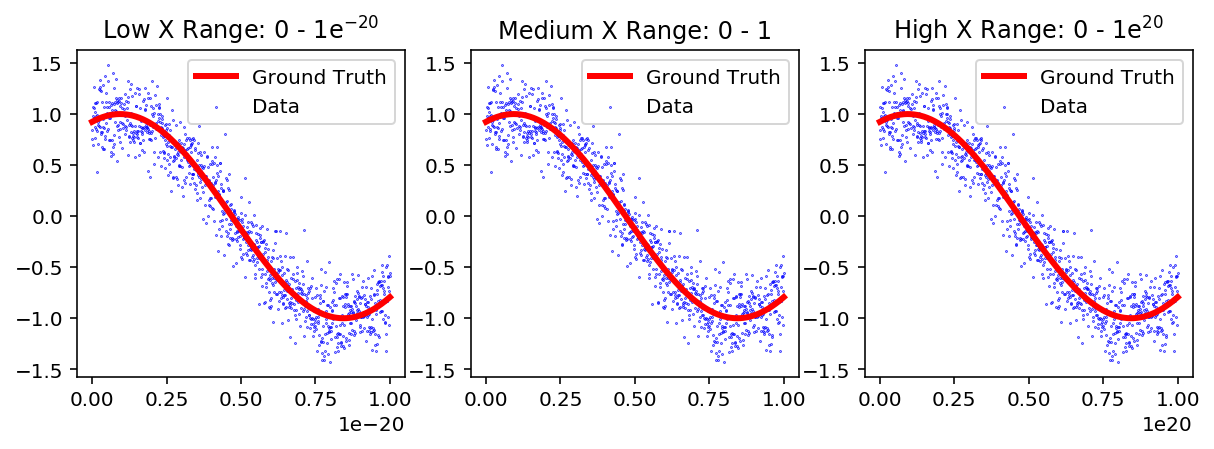

In [4]:
plt.figure(figsize=[10,3])

plot_resuts(1,X_low,y_real,y,'Low X Range: 0 - 1e$^{-20}$')
plot_resuts(2,X_med,y_real,y,'Medium X Range: 0 - 1')
plot_resuts(3,X_high,y_real,y,'High X Range: 0 - 1e$^{20}$')

It can be observed that although the $X$-axis is different, the $y$-axis is the same.

#### Fitting to a Linear Regression Model

We will use a Linear Regression model to fit the data to the only feature we have $X$.  The model is described by:

<center>$y = \beta X$</center>

In [5]:
def fit_model_1(X, y):
    if len(X.shape)==1:
        X2 = X.reshape(-1,1)
    else:
        X2 = X
    reg = linear_model.LinearRegression(fit_intercept=False)
    reg.fit(X2,y)
    y_pred = reg.predict(X2)
    return y_pred   

In [6]:
y_pred_low = fit_model_1(X_low,y)
y_pred_med = fit_model_1(X_med,y)
y_pred_high = fit_model_1(X_high,y)

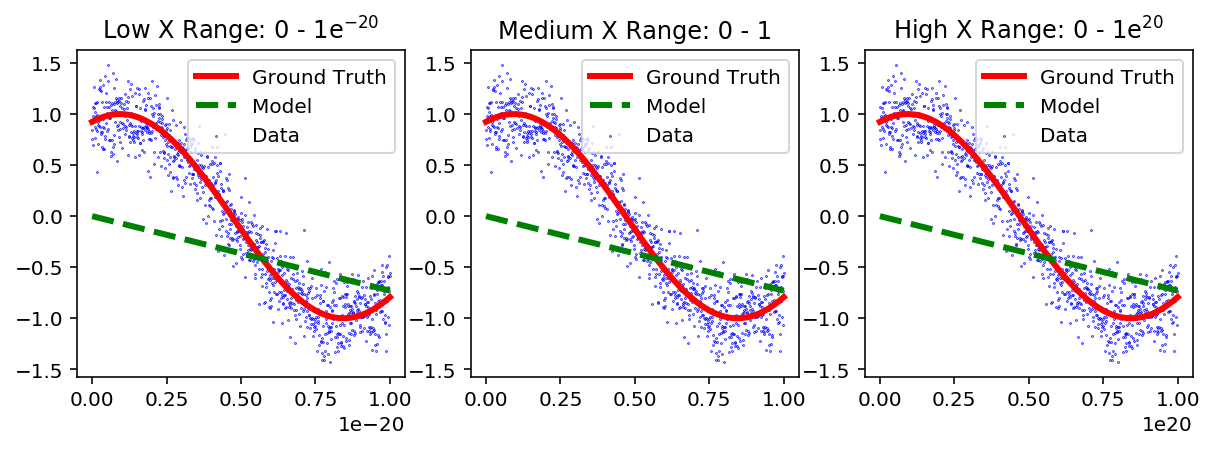

In [7]:
plt.figure(figsize=[10,3])

plot_resuts(1,X_low,y_real,y,'Low X Range: 0 - 1e$^{-20}$',y_pred_low)
plot_resuts(2,X_med,y_real,y,'Medium X Range: 0 - 1',y_pred_med)
plot_resuts(3,X_high,y_real,y,'High X Range: 0 - 1e$^{20}$',y_pred_high)

### Making Polynomials

We observe that the model is very similar for all ranges of $X$.  However, a straight line is not a good model to fit to the data.  To improve the model we can add complexity by creating more features using a $3^{rd}$ order polynomial.  The new model will have the following form:

<center>$y = \beta_0 + \beta_1X + \beta_2X^2 + \beta_3X^3$</center>

Therefore, for every datapoint we will have a new vector $X_i'$ given by:

<center>$X_i' = [ 1 , X_i , X_i^2 , X_i^3 ]$</center>

The vector will have a length of 4 because it includes the bias (intercept) term 1.

In [8]:
def make_poly(deg, X, bias=True):
    p = PolynomialFeatures(deg,include_bias=bias) # adds the intercept column
    X = X.reshape(-1,1)
    X_poly = p.fit_transform(X)
    return X_poly

In [9]:
deg = 3
X_low_poly = make_poly(deg,X_low)
X_med_poly = make_poly(deg,X_med)
X_high_poly = make_poly(deg,X_high)

In [10]:
y_pred_low_poly = fit_model_1(X_low_poly,y)
y_pred_med_poly = fit_model_1(X_med_poly,y)
y_pred_high_poly = fit_model_1(X_high_poly,y)

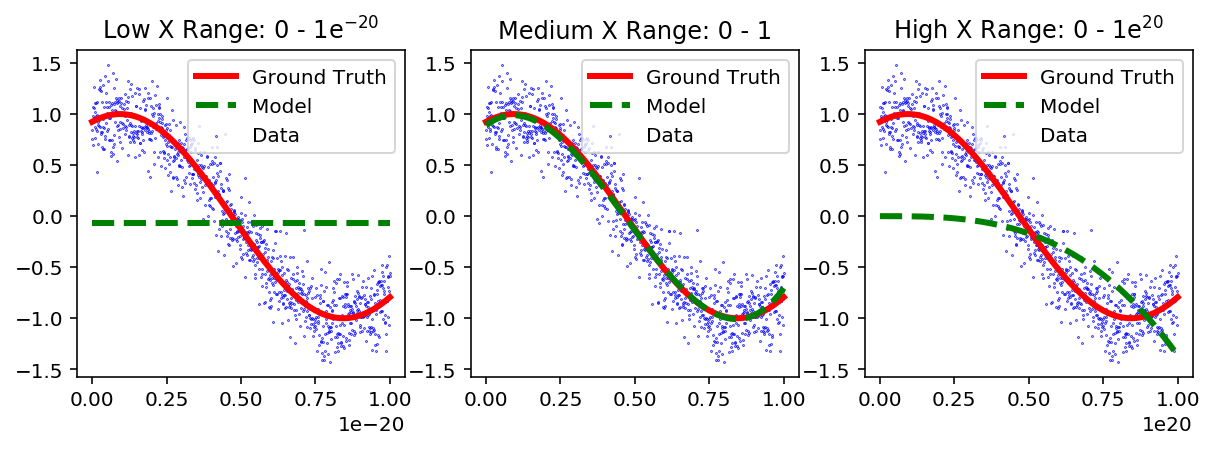

In [11]:
plt.figure(figsize=[10,3])

plot_resuts(1,X_low,y_real,y,'Low X Range: 0 - 1e$^{-20}$',y_pred_low_poly)
plot_resuts(2,X_med,y_real,y,'Medium X Range: 0 - 1',y_pred_med_poly)
plot_resuts(3,X_high,y_real,y,'High X Range: 0 - 1e$^{20}$',y_pred_high_poly)

In the figure above, we observe that the model is very different for each range of $X$.  We note that the "Medium" range tends to fit the model well, while the "Low" and "High" range do a poor job. 

This occurs because the range for every feature (polynomial value) is very different for the "Low" and "High" range, but it is similar (or the same) for the "Medium" range.

In the table below, we observe the maximum value for each of the features in the "Low", "Medium" and "High" range. Note that for the "Medium", the maximum value for all features is $1$. However, for the "Low" and "High" ranges, each feature has a very different order of magnitude from $1$ to $1e^{-60}$ or $1e^{60}$.

In [12]:
matrix = pd.DataFrame([pd.DataFrame(X_low_poly).max(),
              pd.DataFrame(X_med_poly).max(),
              pd.DataFrame(X_high_poly).max()],
             index=['$Low$','$Medium$','$High$'])
matrix.columns = (['$Bias$','$X$','$X^2$','$X^3$'])
print('The maximum value for each feature is:')
matrix

The maximum value for each feature is:


,$Bias$,$X$,$X^2$,$X^3$
$Low$,1,1e-20,1e-40,1e-60
$Medium$,1,1,1,1
$High$,1,1e+20,1e+40,1e+60


To address this we can normalize the data.  There are several ways of normalizing the data.  We will use the a method for which we will subtract the mean and divide by the standard deviation.

$$X_i^{norm} = \dfrac{X_i-\mu}{\sigma}$$

In [13]:
def normalize(X_poly):
    # remove the bias column which should not be normalized!
    X_poly_2 = np.delete(X_poly, np.s_[0], 1)
    
    # scale each column
    scaler = StandardScaler()
    X_poly_3 = scaler.fit_transform(X_poly_2)
    
    # re-add the bias term
    ones = np.ones((len(X_poly_3),1))
    X_poly_4 = np.append(ones, X_poly_3, 1)

    return X_poly_4

In [14]:
X_low_poly_norm = normalize(X_low_poly)
X_med_poly_norm = normalize(X_med_poly)
X_high_poly_norm = normalize(X_high_poly)

In [15]:
matrix = pd.DataFrame([pd.DataFrame(X_low_poly_norm).max(),
              pd.DataFrame(X_med_poly_norm).max(),
              pd.DataFrame(X_high_poly_norm).max()],
             index=['$Low$','$Medium$','$High$'])
matrix.columns = (['$Bias$','$X$','$X^2$','$X^3$'])
print('The maximum value for each feature is:')
matrix

The maximum value for each feature is:


,$Bias$,$X$,$X^2$,$X^3$
$Low$,1,1.7,2.2,2.6
$Medium$,1,1.7,2.2,2.6
$High$,1,1.7,2.2,2.6


We observe that now the maximum value for each feature is in the same order of magnitude, and the results are the same for the "Low", "Medium" and "High" ranges.

In [16]:
y_pred_low_poly_norm = fit_model_1(X_low_poly_norm,y)
y_pred_med_poly_norm = fit_model_1(X_med_poly_norm,y)
y_pred_high_poly_norm = fit_model_1(X_high_poly_norm,y)

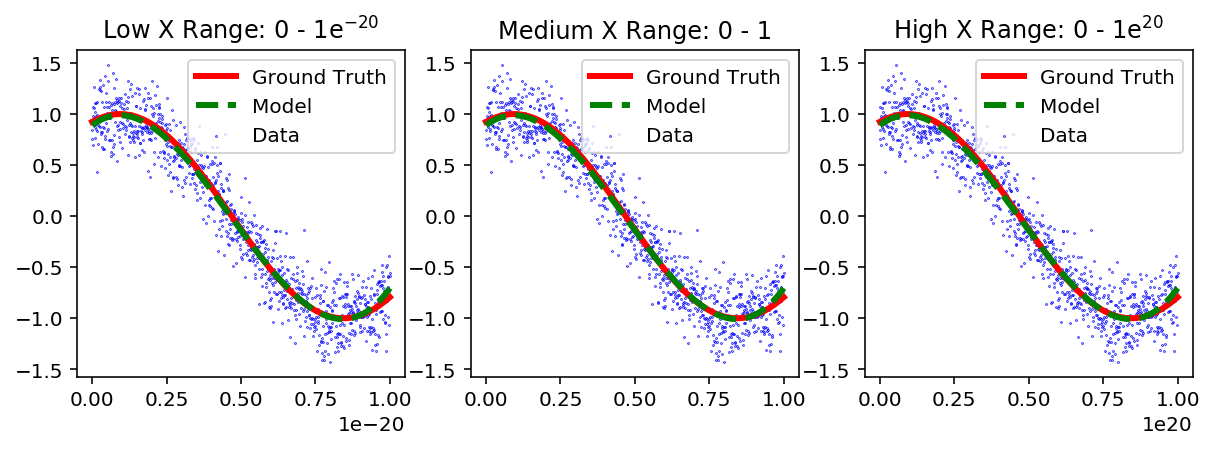

In [17]:
plt.figure(figsize=[10,3])

plot_resuts(1,X_low,y_real,y,'Low X Range: 0 - 1e$^{-20}$',y_pred_low_poly_norm)
plot_resuts(2,X_med,y_real,y,'Medium X Range: 0 - 1',y_pred_med_poly_norm)
plot_resuts(3,X_high,y_real,y,'High X Range: 0 - 1e$^{20}$',y_pred_high_poly_norm)

As expected, after normalizing the features we get an accurate prediction for the $y$-axis.